In [50]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


[nltk_data] Downloading package stopwords to C:\Users\ELITEBOOK 830
[nltk_data]     G6\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
import os
os.getcwd()


'e:\\SEMESTER 5\\Machine_Learning\\TA-13\\src'

In [52]:
with open("../data/INA_TweetsPPKM_Labeled_Pure.csv", encoding="utf-8") as f:
    for i in range(5):
        print(repr(f.readline()))


'Date\tUser\tTweet\tsentiment\n'
'2022-03-31 14:32:04+00:00\tpikobar_jabar\tKetahui informasi pembagian #PPKM di wilayah Jabar berdasarkan level 3, 2 dan 1 di #PikoData https://t.co/o2RnI7eDue\t1\n'
'2022-03-31 09:26:00+00:00\tinewsdotid\t"Tempat Ibadah di Wilayah PPKM Level 1 Boleh Berkapasitas 100 Persen. Baca Selengkapnya di https://t.co/JfIG6nIimN\n'
'#Ramadhan #PPKM #inews https://t.co/ky1G5xYLQB"\t1\n'
'2022-03-31 05:02:34+00:00\tvdvc_talk\t"Juru bicara Satgas Covid-19, Wiku Adisasmito menjelaskan bahwa bukber diperbolehkan dengan menjaga jarak, tidak mengobrol, serta tidak lupa cuci tangan sebelum makan.\n'


In [53]:
import csv
import pandas as pd

rows = []

with open("../data/INA_TweetsPPKM_Labeled_Pure.csv", encoding="utf-8") as f:
    reader = csv.reader(f, delimiter="\t")
    for row in reader:
        if len(row) == 4:   # HARUS 4 kolom: Date, User, Tweet, sentiment
            rows.append(row)

df = pd.DataFrame(rows[1:], columns=rows[0])

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23644 entries, 0 to 23643
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       23644 non-null  object
 1   User       23644 non-null  object
 2   Tweet      23644 non-null  object
 3   sentiment  23644 non-null  object
dtypes: object(4)
memory usage: 739.0+ KB


In [54]:
print(df.columns)
df["sentiment"].value_counts(dropna=False)


Index(['Date', 'User', 'Tweet', 'sentiment'], dtype='object')


sentiment
1    17706
2     3980
0     1958
Name: count, dtype: int64

In [55]:
df = df[["Tweet", "sentiment"]].dropna()
df.rename(columns={"Tweet": "text"}, inplace=True)

df["sentiment"] = df["sentiment"].astype(int)
df["sentiment"].value_counts()


sentiment
1    17706
2     3980
0     1958
Name: count, dtype: int64

In [56]:
def normalize_label(x):
    x = str(x).strip().lower()

    # numerik
    if x in ["1", "1.0"]:
        return 1
    if x in ["0", "0.0"]:
        return 0

    # teks
    if x in ["positif", "positive"]:
        return 1
    if x in ["negatif", "negative"]:
        return 0

    return None


df["sentiment"] = df["sentiment"].apply(normalize_label)
df = df.dropna(subset=["sentiment"])
df["sentiment"] = df["sentiment"].astype(int)

print(df["sentiment"].value_counts())
print("Jumlah data:", len(df))


sentiment
1    17706
0     1958
Name: count, dtype: int64
Jumlah data: 19664


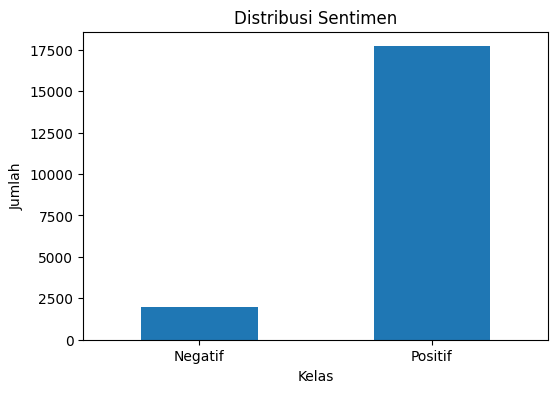

In [57]:
plt.figure(figsize=(6,4))
df["sentiment"].value_counts().sort_index().plot(kind="bar")
plt.xticks([0,1], ["Negatif", "Positif"], rotation=0)
plt.title("Distribusi Sentimen")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()


In [58]:
df["sentiment"].value_counts()


sentiment
1    17706
0     1958
Name: count, dtype: int64

In [59]:
df["sentiment"].unique()[:10]


array([1, 0])

In [60]:
import re

stop_id = set(stopwords.words("indonesian"))

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_id]

    return " ".join(tokens)

df["text_clean"] = df["text"].apply(preprocess)


In [61]:
X = df["text_clean"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data train:", len(X_train))
print("Data test :", len(X_test))


Data train: 15731
Data test : 3933


In [62]:
df.columns


Index(['text', 'sentiment', 'text_clean'], dtype='object')

In [63]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [64]:
svm_linear = LinearSVC(C=1.0)
svm_linear.fit(X_train_tfidf, y_train)

y_pred_linear = svm_linear.predict(X_test_tfidf)

print("Accuracy Linear:", accuracy_score(y_test, y_pred_linear))
print(classification_report(y_test, y_pred_linear))


Accuracy Linear: 0.9229595728451564
              precision    recall  f1-score   support

           0       0.66      0.47      0.55       392
           1       0.94      0.97      0.96      3541

    accuracy                           0.92      3933
   macro avg       0.80      0.72      0.75      3933
weighted avg       0.92      0.92      0.92      3933



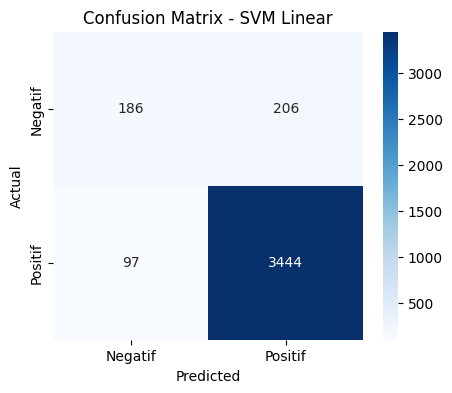

In [65]:
cm_linear = confusion_matrix(y_test, y_pred_linear)

plt.figure(figsize=(5,4))
sns.heatmap(cm_linear, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negatif","Positif"],
            yticklabels=["Negatif","Positif"])
plt.title("Confusion Matrix - SVM Linear")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [66]:
svm_rbf = SVC(kernel="rbf", C=3, gamma="scale")
svm_rbf.fit(X_train_tfidf, y_train)

y_pred_rbf = svm_rbf.predict(X_test_tfidf)

print("Accuracy RBF:", accuracy_score(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))


Accuracy RBF: 0.928044749555047
              precision    recall  f1-score   support

           0       0.73      0.45      0.55       392
           1       0.94      0.98      0.96      3541

    accuracy                           0.93      3933
   macro avg       0.83      0.71      0.76      3933
weighted avg       0.92      0.93      0.92      3933



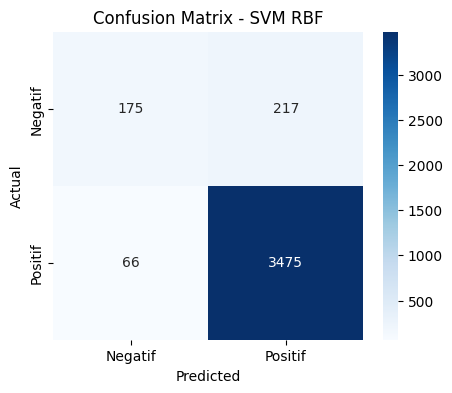

In [67]:
cm_rbf = confusion_matrix(y_test, y_pred_rbf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rbf, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negatif","Positif"],
            yticklabels=["Negatif","Positif"])
plt.title("Confusion Matrix - SVM RBF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [68]:
df["text_clean"] = df["text"].apply(preprocess)


In [69]:
df[["text", "text_clean"]].head()


,text,text_clean
0,Ketahui informasi pembagian #PPKM di wilayah J...,ketahui informasi pembagian wilayah jabar berd...
1,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,ibadah wilayah ppkm level berkapasitas persen ...
2,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",juru bicara satgas covid wiku adisasmito bukbe...
3,Ketahui informasi pembagian #PPKM di wilayah J...,ketahui informasi pembagian wilayah jabar berd...
4,Kementerian Agama menerbitkan Surat Edaran Nom...,kementerian agama menerbitkan surat edaran nom...


In [70]:
print(df["sentiment"].value_counts())
print(df[df["sentiment"] == 1].shape)
df[df["sentiment"] == 1]["text_clean"].head()


sentiment
1    17706
0     1958
Name: count, dtype: int64
(17706, 3)


0    ketahui informasi pembagian wilayah jabar berd...
1    ibadah wilayah ppkm level berkapasitas persen ...
2    juru bicara satgas covid wiku adisasmito bukbe...
3    ketahui informasi pembagian wilayah jabar berd...
4    kementerian agama menerbitkan surat edaran nom...
Name: text_clean, dtype: object

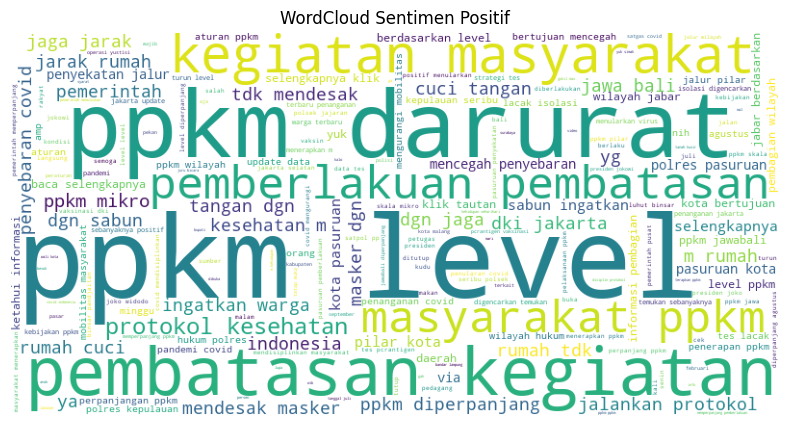

In [72]:
text_pos = " ".join(df[df["sentiment"] == 1]["text_clean"])

wc_pos = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(text_pos)

plt.figure(figsize=(10,5))
plt.imshow(wc_pos.to_image())
plt.axis("off")
plt.title("WordCloud Sentimen Positif")
plt.show()


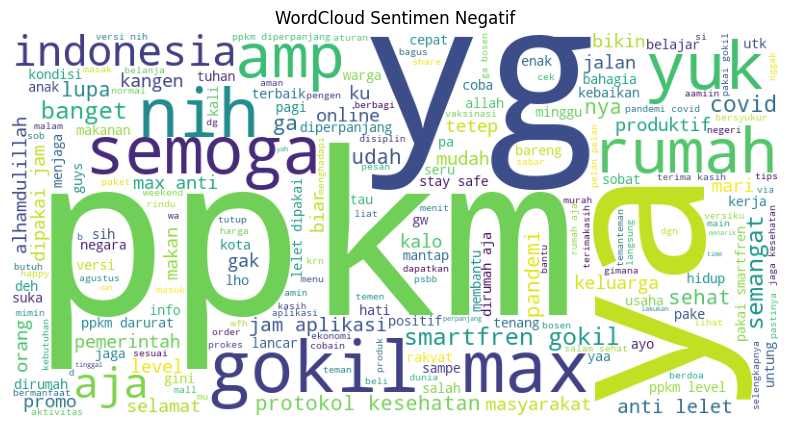

In [73]:
text_neg = " ".join(df[df["sentiment"] == 0]["text_clean"])

wc_neg = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(text_neg)

plt.figure(figsize=(10,5))
plt.imshow(wc_neg.to_image())
plt.axis("off")
plt.title("WordCloud Sentimen Negatif")
plt.show()


In [75]:
X = df["text_clean"]
y = df["sentiment"]

print("Jumlah data:", len(df))
print(y.value_counts())


Jumlah data: 19664
sentiment
1    17706
0     1958
Name: count, dtype: int64


In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Data train:", len(X_train))
print("Data test :", len(X_test))


Data train: 15731
Data test : 3933


In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape


((15731, 5000), (3933, 5000))

In [78]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

svm_linear = LinearSVC(C=1.0)
svm_linear.fit(X_train_tfidf, y_train)

y_pred_linear = svm_linear.predict(X_test_tfidf)

print("Accuracy SVM Linear:", accuracy_score(y_test, y_pred_linear))
print(classification_report(y_test, y_pred_linear))


Accuracy SVM Linear: 0.92372234935164
              precision    recall  f1-score   support

           0       0.65      0.48      0.55       386
           1       0.94      0.97      0.96      3547

    accuracy                           0.92      3933
   macro avg       0.80      0.73      0.76      3933
weighted avg       0.92      0.92      0.92      3933



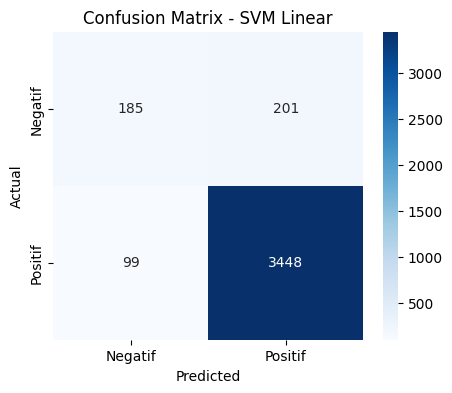

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_linear = confusion_matrix(y_test, y_pred_linear)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_linear,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negatif", "Positif"],
    yticklabels=["Negatif", "Positif"]
)
plt.title("Confusion Matrix - SVM Linear")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [80]:
from sklearn.svm import SVC

svm_rbf = SVC(
    kernel="rbf",
    C=3,
    gamma="scale"
)

svm_rbf.fit(X_train_tfidf, y_train)
y_pred_rbf = svm_rbf.predict(X_test_tfidf)

print("Accuracy SVM RBF:", accuracy_score(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))


Accuracy SVM RBF: 0.9227053140096618
              precision    recall  f1-score   support

           0       0.68      0.40      0.51       386
           1       0.94      0.98      0.96      3547

    accuracy                           0.92      3933
   macro avg       0.81      0.69      0.73      3933
weighted avg       0.91      0.92      0.91      3933



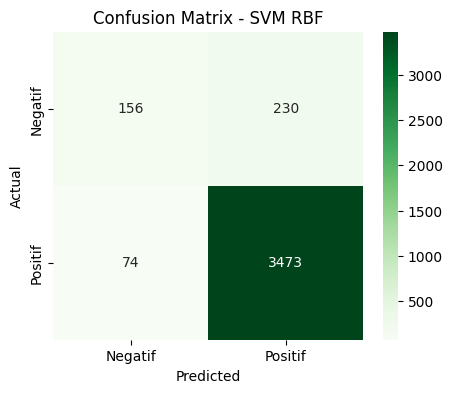

In [81]:
cm_rbf = confusion_matrix(y_test, y_pred_rbf)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_rbf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Negatif", "Positif"],
    yticklabels=["Negatif", "Positif"]
)
plt.title("Confusion Matrix - SVM RBF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [82]:
print("Akurasi Linear :", accuracy_score(y_test, y_pred_linear))
print("Akurasi RBF    :", accuracy_score(y_test, y_pred_rbf))

Akurasi Linear : 0.92372234935164
Akurasi RBF    : 0.9227053140096618


In [74]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("svm", SVC(kernel="rbf"))
])

param_grid = {
    "tfidf__max_features": [3000, 5000],
    "svm__C": [0.1, 1, 10],
    "svm__gamma": [0.01, 0.1, "scale"]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameter:", grid.best_params_)
print("Best Score:", grid.best_score_)


Best Parameter: {'svm__C': 10, 'svm__gamma': 0.1, 'tfidf__max_features': 3000}
Best Score: 0.9582396077418265


In [83]:
import joblib
import os

os.makedirs("model", exist_ok=True)

joblib.dump(svm_linear, "model/svm_linear.pkl")
joblib.dump(tfidf, "model/tfidf.pkl")

print("Model & TF-IDF berhasil disimpan")


Model & TF-IDF berhasil disimpan
